In [1]:
import sys
sys.path.append("..")

import pickle
import time
import pprint
import numpy as np
from tqdm import tqdm
import multiprocessing
from sympy import Symbol, sin, cos, tan, nsimplify
import matplotlib.pyplot as plt
from utils.plot_utils import set_fontsize
# from optical_bloch.utils.general import flatten
# from optical_bloch import Hamiltonian, Dissipator, BlochEquations
from optical_bloch_test.utils.general import flatten
from optical_bloch_test import Hamiltonian, Dissipator, BlochEquations
from multi_helper_funcs import multi_solve_ode, multi_solve_ode_integrate_excited

from julia import Main
from sympy import MutableDenseMatrix, conjugate, Function, Symbol

In [2]:
hbar=1.054*1E-34; #[Js]
k_b=1.381*1E-23; #[J/K]
c=299792000; #[m/s]
eps_0=8.854*1E-12; #[F/m]
a0=5.29*1E-11; #[m]
q_e=1.602*1E-19; #[C]
Bohr_mag=1.39962449/1000*2*np.pi; #[GHz/G]

nground = 7
nexcite = 5
ntotal = nground + nexcite

In [3]:
rabi_matrix = np.zeros([ntotal,ntotal,3])
rabi_matrix[:,:,0] = np.genfromtxt('rabimatrix75toy1.csv',delimiter=',')
rabi_matrix[:,:,1] = np.genfromtxt('rabimatrix75toy2.csv',delimiter=',')
rabi_matrix[:,:,2] = np.genfromtxt('rabimatrix75toy3.csv',delimiter=',')

In [4]:
E0 = Symbol(u'E0', real = True)
Ee = Symbol(u'Ee', real = True)

ω = Symbol(u'ω', real = True)
Ω = Symbol(u'Ω', real = True)
Δ = Symbol(u'Δ', real = True)
g = Symbol(u'g', real = True)

θ = Symbol(u'θ', real = True)
B = Symbol(u'B', real = True)

In [5]:
ham = Hamiltonian(ntotal)
ham.addEnergies([E0-3*g*B,E0-2*g*B,E0-g*B,E0,E0+g*B, E0+2*g*B,E0+3*g*B,
                 Ee,Ee,Ee,Ee,Ee])
# ham.addEnergies([E0-2*g*B,E0-g*B,E0,E0+g*B, E0+2*g*B,
#                  Ee-g*B,Ee,Ee+g*B])

In [6]:
for i in range(nground):
    for j in range(nground, ntotal):
        if rabi_matrix[i, j, 0] != 0:
            prefactor = (-1)/np.sqrt(2)*sin(θ)
            ham.addCoupling(i, j, prefactor*Ω*rabi_matrix[i,j,0], ω)
        if rabi_matrix[i, j, 1] != 0:
            prefactor = (1)*cos(θ)
            ham.addCoupling(i, j, prefactor*Ω*rabi_matrix[i,j,1], ω)
        if rabi_matrix[i, j, 2] != 0:
            prefactor = (1)/np.sqrt(2)*sin(θ)
            ham.addCoupling(i, j, prefactor*Ω*rabi_matrix[i,j,2], ω)

In [7]:
ham.eqnTransform()
ham.defineZero(Ee)
ham.defineEnergyDetuning(E0, Ee, Δ, ω)

In [8]:
ham.transformed

Matrix([
[             -3*B*g - 1.0*Δ,                           0,                           0,                          0,                            0,                          0,                          0, -0.223606797749979*Ω*sin(θ),                           0,                          0,                          0,                            0],
[                          0,              -2*B*g - 1.0*Δ,                           0,                          0,                            0,                          0,                          0,  0.182574185835055*Ω*cos(θ), -0.182574185835055*Ω*sin(θ),                          0,                          0,                            0],
[                          0,                           0,                -B*g - 1.0*Δ,                          0,                            0,                          0,                          0, 0.0577350269189625*Ω*sin(θ),   0.23094010767585*Ω*cos(θ), -0.14142135623731*Ω*sin(θ),          

In [9]:
ham.hamiltonian

Matrix([
[                                -3*B*g + E0,                                           0,                                           0,                                          0,                                            0,                                          0,                                          0, -0.223606797749979*Ω*exp(1.0*I*t*ω)*sin(θ),                                          0,                                         0,                                         0,                                           0],
[                                          0,                                 -2*B*g + E0,                                           0,                                          0,                                            0,                                          0,                                          0,  0.182574185835055*Ω*exp(1.0*I*t*ω)*cos(θ), -0.182574185835055*Ω*exp(1.0*I*t*ω)*sin(θ),                                         0,             

In [10]:
transition_strengths=np.zeros([ntotal,ntotal]);
for i in range(ntotal):
    for f in range(ntotal):
        for p in range(3):
            transition_strengths[i,f]=transition_strengths[i,f]+rabi_matrix[i,f,p]**2

In [11]:
BR = np.zeros([ntotal, ntotal])
for i in range(ntotal):
    sums=0
    for f in range(ntotal):
        sums=sums+transition_strengths[i,f]
        
    for f in range(ntotal):
        BR[i,f]=transition_strengths[i,f]/sums
        
for i in range(nground):
    BR[i,:]=0

In [13]:
BR[nground:,:]

array([[0.71428571, 0.23809524, 0.04761905, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.47619048, 0.38095238, 0.14285714, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.28571429, 0.42857143, 0.28571429,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.14285714, 0.38095238,
        0.47619048, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.04761905,
        0.23809524, 0.71428571, 0.        , 0.        , 0.        ,
        0.        , 0.        ]])

In [14]:
Γ = Symbol(u'Γ', real = True)
dis = Dissipator(ntotal)

for exct in tqdm(range(nground, ntotal)):
    for grnd in range(nground):
        if BR[exct, grnd] != 0:
            dis.addDecay(exct, grnd, Γ * BR[exct, grnd])

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.15s/it]


In [15]:
dis.dissipator

Matrix([
[0.714285714285714*Γ*ρ₇₇(t),                                                       0,                                                                                   0,                                                                                  0,                                                                                   0,                                                       0,                          0,            -0.5*Γ*ρ₀₇(t),            -0.5*Γ*ρ₀₈(t),            -0.5*Γ*ρ₀₉(t),            -0.5*Γ*ρ₀₊(t), -0.5*Γ*ρ₀₋(t)],
[                         0, Γ*(0.238095238095238*ρ₇₇(t) + 0.476190476190476*ρ₈₈(t)),                                                                                   0,                                                                                  0,                                                                                   0,                                                       0,                          0,            -0.5*Γ*ρ₁₇

In [16]:
%%time
bloch = BlochEquations(ntotal, dis.density_matrix, ham.transformed, dis.dissipator)

start generateEquations
start generateSteadyStateDensityMatrix
start generateEquationsSteadyState
Wall time: 39.4 s


In [30]:
Ω_value = 0.5
replacements = [(g, 1),
                (Δ, 0),
                (Ω, Ω_value),
                (Γ, 1)]

In [34]:
varlist1 = np.linspace(0.01,np.pi,50)
varlist2 = 10**np.linspace(-3,1,50)
# np.linspace(0.001,5,100)
sol = bloch.solveSteadyStateNumeric(replacements = replacements, parameters_scan = [θ, B], scan_ranges = [varlist1, varlist2])

100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 414.02it/s]


In [35]:
soltemp = sol.reshape([len(varlist1), len(varlist2), ntotal, ntotal])
ρii = np.array([np.real(soltemp[:,:,i,i]) for i in range(ntotal)])

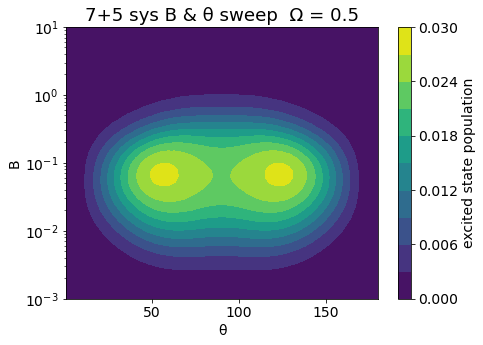

In [36]:
fig, ax = plt.subplots(figsize = (7,5))

params = np.array(np.meshgrid(varlist1, varlist2)).T.reshape(-1,2)

tcf = ax.tricontourf(params[:,0]*180/np.pi, params[:,1], 
                     np.sum(np.array([ρii[_,:,:].reshape(len(varlist1)*len(varlist2)) 
                                      for _ in range(nground, ntotal)]), axis = 0) ,levels=10)

cbar = fig.colorbar(tcf)

ax.set_xlabel('θ')
ax.set_ylabel('B')
cbar.ax.set_ylabel('excited state population')
ax.set_yscale('log')
ax.set_title(f'7+5 sys B & θ sweep  Ω = {Ω_value}')
set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio

In [44]:
filenames = []
y = np.concatenate((np.linspace(0.1, 2, 20), np.linspace(2.2, 8, 20)), axis=None)

for i in y:
    Ω_value = i
    replacements = [(g, 1),
                    (Δ, 0),
                    (Ω, Ω_value),
                    (Γ, 1)]
    
    varlist1 = np.linspace(0.01,np.pi,50)
    varlist2 = 10**np.linspace(-3,1,50)
    sol = bloch.solveSteadyStateNumeric(replacements = replacements, parameters_scan = [θ, B], scan_ranges = [varlist1, varlist2])
    soltemp = sol.reshape([len(varlist1), len(varlist2), ntotal, ntotal])
    ρii = np.array([np.real(soltemp[:,:,i,i]) for i in range(ntotal)])
    
    fig, ax = plt.subplots(figsize = (7,5))

    params = np.array(np.meshgrid(varlist1, varlist2)).T.reshape(-1,2)
    tcf = ax.tricontourf(params[:,0]*180/np.pi, params[:,1], 
                         np.sum(np.array([ρii[_,:,:].reshape(len(varlist1)*len(varlist2)) 
                                          for _ in range(nground, ntotal)]), axis = 0) ,levels=10)

    cbar = fig.colorbar(tcf)

    ax.set_xlabel('θ')
    ax.set_ylabel('B')
    cbar.ax.set_ylabel('excited state population')
    ax.set_yscale('log')
    ax.set_title(f'7+5 sys B & θ sweep  Ω = {Ω_value}')
    set_fontsize(ax, 14)
    set_fontsize(cbar.ax, 14)
    
    # create file name and append it to a list
    filename = f'{i}.png'
    for i in range(10):
        filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()
    
# build gif
with imageio.get_writer('7+5 sys 2.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 399.17it/s]


In [ ]:
θ

In [136]:
B_value = 6
Ω_value = 50
replacements = [(g, 1),
                (B, B_value),
                (Δ, 0),
                (Ω, Ω_value),
                (Γ, 1)]

In [137]:
varlist = np.linspace(0.01,np.pi,100)
sol = bloch.solveSteadyStateNumeric(replacements = replacements, parameters_scan = θ, scan_ranges = [varlist])
arr = np.array([[-np.sqrt(6)*np.sin(θ), np.sqrt(6)*np.cos(θ), -np.sin(θ),
                -np.sqrt(3)*np.sin(θ), np.sqrt(8)*np.cos(θ), -np.sqrt(3)*np.sin(θ),
                -np.sin(θ), np.sqrt(6)*np.cos(θ), -np.sqrt(6)*np.sin(θ)] for θ in varlist])

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1481.69it/s]


In [138]:
soltemp = sol.reshape([-1,8,8])
ρii = np.array([np.real(soltemp[:,i,i]) for i in range(8)])
std = np.array([np.sum(np.abs(arr[i])) for i in range(len(arr))])

Text(0.5, 0.98, '5+3 sys  $B$ = 6  Ω = 50  X = angle')

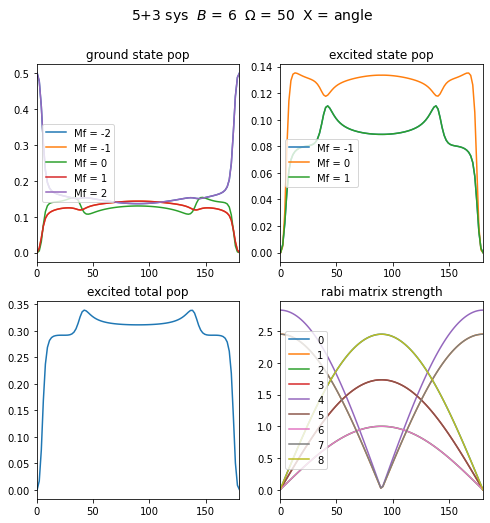

In [139]:
fig, ax = plt.subplots(2,2, figsize = (8,8))
for _ in range(0,5):
    ax[0,0].plot(varlist/np.pi*180, ρii[_,:], label = "Mf = "+str(_-2))
for _ in range(5,8):
    ax[0,1].plot(varlist/np.pi*180, ρii[_,:], label = "Mf = "+str(_-6))
ax[1,0].plot(varlist/np.pi*180, ρii[5,:]+ρii[6,:]+ρii[7,:])

for i in range(9):
    ax[1,1].plot(varlist/np.pi*180, np.abs(arr[:,i]), label = str(i))
ax[0,0].legend(loc = 6)
ax[0,1].legend(loc = 6)
# ax[1,0].legend()
ax[1,1].legend(loc = 6)
ax[0,0].set_xlim(0,180)
ax[0,1].set_xlim(0,180)
ax[1,0].set_xlim(0,180)
ax[1,1].set_xlim(0,180)
ax[0,0].set_title('ground state pop')
ax[0,1].set_title('excited state pop')
ax[1,0].set_title('excited total pop')
ax[1,1].set_title('rabi matrix strength')
fig.suptitle(f"5+3 sys  $B$ = {B_value}  Ω = {Ω_value}  X = angle", fontsize=14)
# fig.supxlabel('1')

Text(0.5, 1.0, '5+3 sys ground state rabi frequency')

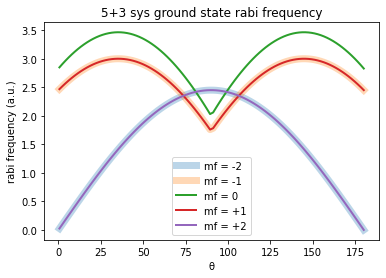

In [146]:
fig, ax = plt.subplots(figsize = (6,4))
ax.plot(varlist/np.pi*180, np.abs(arr[:,0])**1, label = 'mf = -2', lw = 7, alpha = 0.3)
ax.plot(varlist/np.pi*180, np.abs(arr[:,1])**1 + np.abs(arr[:,3])**1, label = 'mf = -1', lw = 7, alpha = 0.3)
ax.plot(varlist/np.pi*180, np.abs(arr[:,2])**1 + np.abs(arr[:,4])**1 + np.abs(arr[:,6])**1, label = 'mf = 0', lw = 2)
ax.plot(varlist/np.pi*180, np.abs(arr[:,5])**1 + np.abs(arr[:,7])**1, label = 'mf = +1', lw = 2)
ax.plot(varlist/np.pi*180, np.abs(arr[:,8])**1, label = 'mf = +2', lw = 2)
plt.legend()
plt.xlabel('θ')
plt.ylabel('rabi frequency (a.u.)')
plt.title('5+3 sys ground state rabi frequency')

Text(0.5, 1.0, 'total rabi frequency')

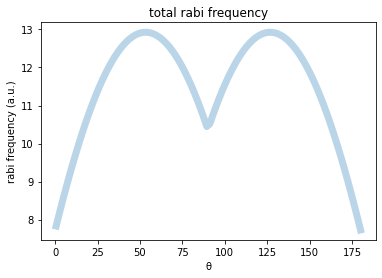

In [147]:
fig, ax = plt.subplots(figsize = (6,4))
ax.plot(varlist/np.pi*180, np.sum(np.array([np.abs(arr[:,_]) for _ in range(9)]),axis=0), label = 'mf = -2', lw = 7, alpha = 0.3)
# ax.plot(varlist/np.pi*180, , label = 'mf = -1', lw = 7, alpha = 0.3)
# ax.plot(varlist/np.pi*180, , label = 'mf = 0', lw = 2)
# ax.plot(varlist/np.pi*180, np.abs(arr[:,5])**1 + np.abs(arr[:,7])**1, label = 'mf = +1', lw = 2)
# ax.plot(varlist/np.pi*180, np.abs(arr[:,8])**1, label = 'mf = +2', lw = 2)
# plt.legend()
plt.xlabel('θ')
plt.ylabel('rabi frequency (a.u.)')
plt.title('total rabi frequency')

In [20]:
from sympy import *

In [234]:
c = Symbol(u'c')
gamma = 1
omega = np.sqrt(3)/9
temp2 = omega**4 / 16/0.1**2 + 16*0.1**2
delta = 0
temp = (gamma/2)**2 + omega**2 * c * (1-3*c) / (1+3*c) + c/(1+3*c)*temp2
P = omega**2 * c * (1-c) / (1 + 3*c) / (temp**2 + delta**2)
# P = omega**2 * c * (1-c) / (1 + 3*c)

cos^2 = 0.31313131313131315
angle = 55.97314815295484


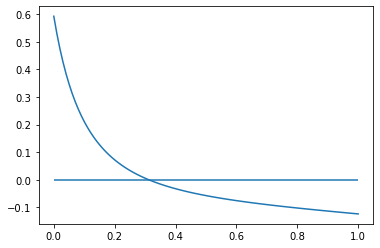

In [235]:
dif = diff(P,c)
clist = np.linspace(0,1,100)
plt.plot(clist, [dif.subs(c,i) for i in clist])
indextemp = np.where(np.array([dif.subs(c,i) for i in clist]) < 0 )[0][0]
plt.hlines(0,0,1)
print('cos^2 = '+str(clist[indextemp]))
print('angle = '+str(180/np.pi*np.arccos(np.sqrt(clist[indextemp]))))

In [46]:
replacements = [(g, 1),
                (θ, 90/180*np.pi),
                (B, 0.7),
                (Δ, 0),
                (Ω, 1),
                (Γ, 1)]
sol = bloch.solveSteadyStateSymbolic(replacements = replacements)
print("Steady-state solution :\n")
for key in [bloch.density_matrix_steady_state[i,i] for i in range(8)]:
    try:
        print(f"{str(key):<15} : {sol[key]:.6f}")
    except:
        print(f"{str(key):<15} : {str(sol[key])}")
    finally:
        continue

Steady-state solution :

ρ₀₀             : 0.236000
ρ₁₁             : 0.195260
ρ₂₂             : 0.111857
ρ₃₃             : 0.195260
ρ₄₄             : 0.236000
ρ₅₅             : 0.007321
ρ₆₆             : 0.010981
ρ₇₇             : 0.007321


In [47]:
replacements = [(g, 1),
                (θ, 40/180*np.pi),
                (B, 0.7),
                (Δ, 0),
                (Ω, 1),
                (Γ, 1)]
sol = bloch.solveSteadyStateSymbolic(replacements = replacements)
print("Steady-state solution :\n")
for key in [bloch.density_matrix_steady_state[i,i] for i in range(8)]:
    try:
        print(f"{str(key):<15} : {sol[key]:.6f}")
    except:
        print(f"{str(key):<15} : {str(sol[key])}")
    finally:
        continue

Steady-state solution :

ρ₀₀             : 0.414393
ρ₁₁             : 0.068072
ρ₂₂             : 0.020048
ρ₃₃             : 0.068072
ρ₄₄             : 0.414393
ρ₅₅             : 0.005591
ρ₆₆             : 0.003839
ρ₇₇             : 0.005591


In [17]:
sol = bloch.solveSteadyStateSymbolic(replacements = replacements)
print("Steady-state solution :\n")
# for key in flatten([bloch.density_matrix_steady_state[i,i:] for i in \
#                     range(bloch.density_matrix_steady_state.rows)]):
#     try:
#         print(f"{str(key):<15} : {sol[key]:.3f}")
#     except:
#         print(f"{str(key):<15} : {str(sol[key])}")
#     finally:
#         continue
    
for key in [bloch.density_matrix_steady_state[i,i] for i in range(8)]:
    try:
        print(f"{str(key):<15} : {sol[key]:.6f}")
    except:
        print(f"{str(key):<15} : {str(sol[key])}")
    finally:
        continue

Steady-state solution :

ρ₀₀             : 0.236000
ρ₁₁             : 0.195260
ρ₂₂             : 0.111857
ρ₃₃             : 0.195260
ρ₄₄             : 0.236000
ρ₅₅             : 0.007321
ρ₆₆             : 0.010981
ρ₇₇             : 0.007321


In [258]:
varlist = np.linspace(2,3,2)
replacements_all = [[(g, 1),
                (θ, var),
                (B, 2),
                (Δ, 0),
                (Ω, 1),
                (Γ, 1)] for var in varlist]

In [ ]:
for i in range(len(varlist)):
    sol = bloch.solveSteadyStateSymbolic(replacements = replacements)


In [18]:
y0 = np.zeros([ntotal, ntotal], dtype = complex)
for i in range(nground):
    y0[i,i] = 1/nground
y0 = y0.flatten()

In [16]:
nprocs = 10 # number of processes to use for EnsembleDistributed 
Main.eval(f"""
using BenchmarkTools
using Distributed
""")

if Main.eval("nprocs()") < nprocs:
    Main.eval(f"addprocs({nprocs}-nprocs())")

if Main.eval("nprocs()") > nprocs:
    addprocs({nprocs})
    procs = Main.eval("procs()")
    procs = procs[nprocs:]
    Main.eval(f"rmprocs({procs})")

Main.eval("""
@everywhere begin
    using ModelingToolkit
    using LinearAlgebra
    using Trapz
    using DifferentialEquations
    using ModelingToolkit
end
""")

    
Main.eval("procs()")

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [17]:
from sympy import MutableDenseMatrix, conjugate, Function, Symbol

t = Symbol('t', real = True)

hamiltonian_symbols = ham.transformed.free_symbols
dissipator_symbols = dis.dissipator.free_symbols
dissipator_symbols = set([d for d in dissipator_symbols if str(d)[0] not in ['ρ', 't']])

for s in list(hamiltonian_symbols) + list(dissipator_symbols):
    Main.eval(f"""
                @everywhere @parameters {str(s)}
                tmp = 0
            """);


lx, ly = ham.transformed.shape
Main.eval(f"""
            @everywhere begin
            H = zeros(Num, {lx}, {ly})
            L = zeros(Num, {lx}, {ly})
            @variables t ρ[1:{lx},1:{ly}](t)
            @parameters icomplex
            D = Differential(t)
            tmp = 0
            end
            """);

# the code below is to transform the symbolic version of Sympy into a form usable with Julia
diss = MutableDenseMatrix(dis.dissipator.copy())

for i in range(lx):
    for j in range(i,ly):
        tmp = Function(u'ρ{0}{1}'.format(chr(0x2080+i), 
                                         chr(0x2080+j)))
        tmp1 = Function(u'ρ[{0},{1}]'.format(j+1, i+1))
        diss = diss.subs(conjugate(tmp(t)), tmp1(t))
            
for i in range(lx):
    for j in range(i,ly):
        tmp = Function(u'ρ{0}{1}'.format(chr(0x2080+i), 
                                         chr(0x2080+j)))
        tmp1 = Function(u'ρ[{0},{1}]'.format(i+1, j+1))
        diss = diss.subs(tmp(t), tmp1(t))


# Creating the Hamiltonian matrix and Dissipator matrix in Julia
for idx in range(1,lx+1):
    for idy in range(1,ly+1):
        hval = str(ham.transformed[idx-1,idy-1])
        dval = str(diss[idx-1, idy-1])
        dval = dval.replace('(t)', '')
        Main.eval(f"""
                @everywhere begin
                H[{idx},{idy}] = {hval}
                L[{idx},{idy}] = {dval}
                tmp = 0
                end
                """);
        
# ham_pars = ham.transformed.free_symbols

In [18]:
# Creating the system of equations
ham_string = ','.join([str(h) for h in hamiltonian_symbols])
diss_string = ','.join([str(d) for d in dissipator_symbols])

Main.eval(f"""
@everywhere begin
    eq = -icomplex*Symbolics.scalarize(H*ρ-ρ*H) + L
    eqns = [D(ρ[idx,idy]) ~ eq[idx,idy] for idx in 1:{lx} for idy in 1:{ly}];
    bloch = ODESystem(eqns)
    tmp = 0
end
""");

In [19]:
# initial populations
y0 = np.zeros([ham.levels, ham.levels], dtype = complex)
# for _ in range(n):
#     y0[_,_] = 1/nground
y0[1,1] = 1
Main.ρ_ini = y0
Main.eval("@everywhere ρ_ini = $ρ_ini")

In [20]:
print(hamiltonian_symbols,dissipator_symbols)

{Δ, B, θ, g, Ω} {Γ}


In [21]:
Main.eval("""
    @everywhere begin
    Γ_val = 1
    Δgroup = 0E-3
    Ω_val = 3*Γ_val
    u0 = [ρ[idx,idy] => ρ_ini[idx,idy] for idx in 1:size(ρ_ini)[1] for idy in 1:size(ρ_ini)[1]]
    tmp =0;
end
""");

In [22]:
# setting up the parameters of the model and initial conditions
Main.eval("""
    @everywhere begin
    p = [
    θ => 60*pi/180,
    B => 3,
    Δ => Δgroup,
    Ω => Ω_val,
    g => 1,
    Γ => Γ_val,
    icomplex => im
    ]
    u0 = [ρ[idx,idy] => ρ_ini[idx,idy] for idx in 1:size(ρ_ini)[1] for idy in 1:size(ρ_ini)[1]]
    tmp =0;
end
""");

In [23]:
# creating the problem to solve
Main.eval("""
@everywhere begin
    tspan = (0.0, 3000.)
    prob = ODEProblem(bloch, ρ_ini, tspan, p, jac = true)
end
""");

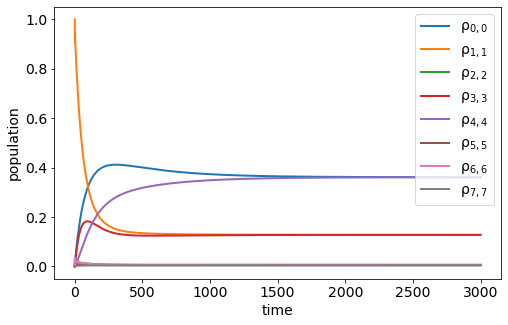

In [24]:
# solving the ODEProblem, keep in mind that the first run compiles called functions
# the first run will be significantly slower (due to compilation), but any subsequent solves are fast
Main.eval("@time sol = solve(prob, Tsit5(), abstol = 1e-10, reltol = 1e-10)");
ut = np.array(Main.eval("sol[:]"))
dim = int(np.sqrt(ut.shape[1]))
pop_results = np.real(np.einsum('jji->ji',ut.reshape(-1,dim, dim).T))
t_array = Main.eval("sol.t") 
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ax.plot(t_array, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$")

ax.set_xlabel('time')
ax.set_ylabel('population')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

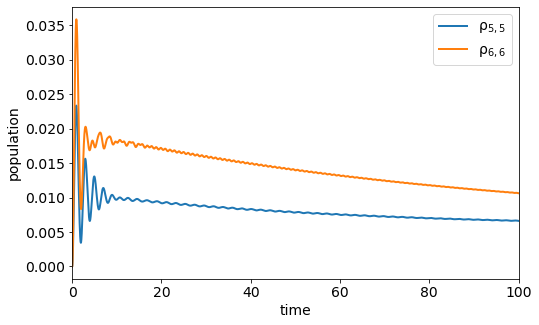

In [25]:
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    if idx in [5,6]:
        ax.plot(t_array, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$")

ax.set_xlabel('time')
ax.set_ylabel('population')
ax.set_xlim([0,100])
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

# sweep one parameter at a time and monitor population change
## sweep angle at low B, Omega = Gamma

In [242]:
# creating the parameter space to scan
varlist = np.linspace(0,np.pi/2,21)
params = varlist

Main.params = params
Main.eval("@everywhere params = $params")

y0 = np.zeros([ham.levels, ham.levels], dtype = complex)
for _ in range(nground):
    y0[_,_] = 1/nground
# y0[1,1] = 0.5
# y0[2,2] = 0.5
Main.ρ_ini = y0
Main.eval("@everywhere ρ_ini = $ρ_ini")

Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    pnew = ModelingToolkit.varmap_to_vars([
        θ => params[i],
        B => 0.001,
        Δ => 0,
        Ω => 1,
        g => 1,
        Γ => 1,
        icomplex => im
        ], parameters(bloch))
   remake(prob, u0 = ρ_ini, p = pnew, tspan = (0.0, 30000.))
end
""")

Main.eval("""
@everywhere function output_func(sol,i)
           return [sol.t, real(sol.u)], false
       end
""")

Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [243]:
# solve the EnsembleProblem
# EnsembleDistributed() is the parallel solver method. See DifferentialEquations.jl for more options.
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                   save_everystep = true; trajectories = size(params)[1], adaptive=true, 
                   abstol = 1e-9, reltol =1e-6)
sim.elapsedTime
""")

1.3298992

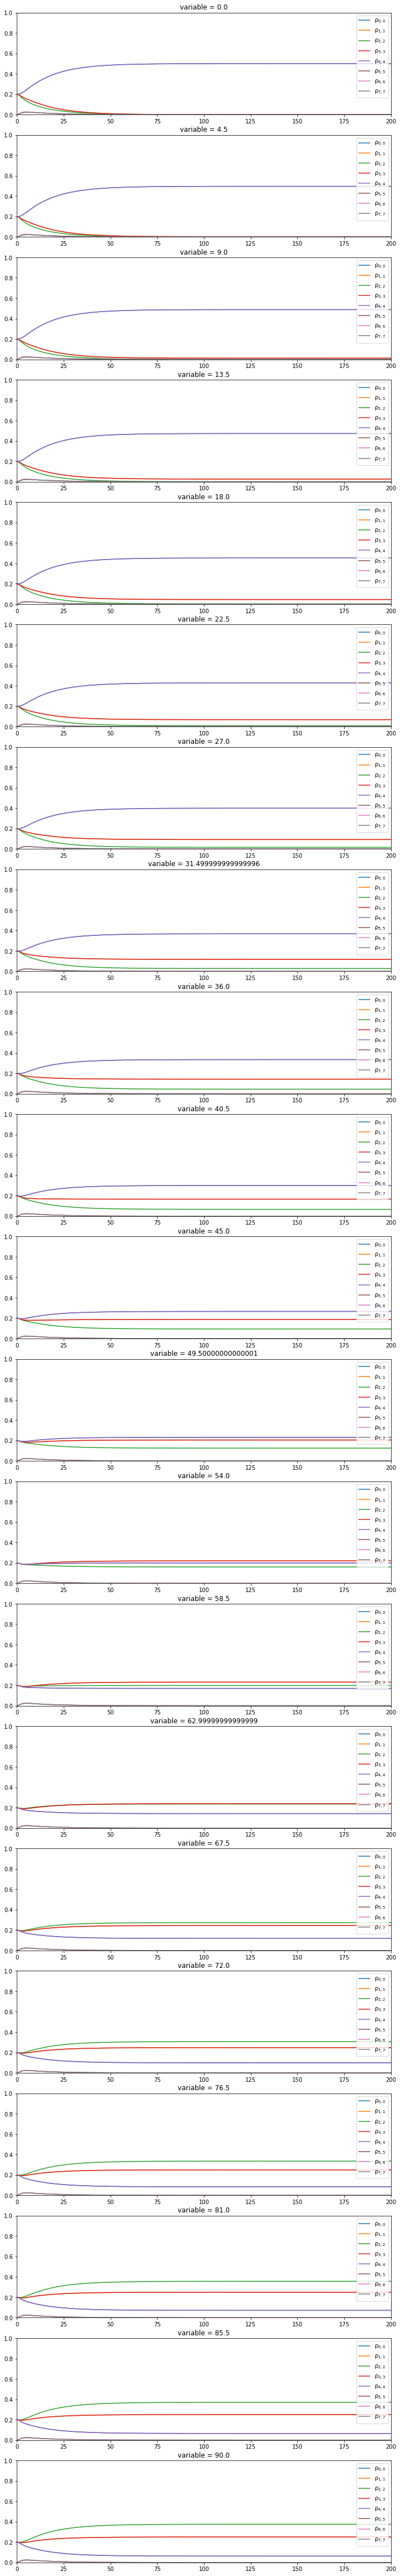

In [244]:
ρ_equ = np.zeros([len(varlist), ntotal, ntotal])
fig, ax = plt.subplots(len(varlist), 1, figsize = (12, len(varlist)*4))
for varindex in range(len(varlist)):
    time = np.array(Main.eval(f"sim.u[{varindex+1}][1]"))
    population = np.array(Main.eval(f"sim.u[{varindex+1}][2]")).reshape(-1, ntotal, ntotal)
    ρ_equ[varindex, :, :] = population[-1, :, :]
    for stateindex in range(ntotal):
#         ax[varindex,0].plot(time, population[:,stateindex, stateindex], label = f"ρ$_{{{stateindex},{stateindex}}}$")
#         ax[varindex,0].legend(loc = 1)
#         ax[varindex,0].set_ylim([0, 1])
# #         ax[varindex].set_xlim([0, 200])
#         titletemp = varlist[varindex]/np.pi*180
#         ax[varindex,0].set_title(f"variable = {titletemp}")
        
        ax[varindex].plot(time, population[:,stateindex, stateindex], label = f"ρ$_{{{stateindex},{stateindex}}}$")
        ax[varindex].legend(loc = 1)
        ax[varindex].set_ylim([0, 1])
#         ax[varindex].set_xlim([0, 200])
        titletemp = varlist[varindex]/np.pi*180
        ax[varindex].set_title(f"variable = {titletemp}")
#         if stateindex < 5:
#             ax[varindex,1].plot(time, population[:,stateindex, stateindex], label = f"ρ$_{{{stateindex},{stateindex}}}$")
#             ax[varindex,1].legend(loc = 1)
#             ax[varindex,1].set_ylim([0, 1])
#             ax[varindex,1].set_xlim([0, 10000])
#             ax[varindex,1].set_title('ground state evolution')
#             titletemp = varlist[varindex]/np.pi*180
            
#         if stateindex > 4:
#             ax[varindex,2].plot(time, population[:,stateindex, stateindex], label = f"ρ$_{{{stateindex},{stateindex}}}$")
#             ax[varindex,2].legend(loc = 1)
#             ax[varindex,2].set_ylim([0, 0.2])
#             ax[varindex,2].set_xlim([0, 1000])
#             ax[varindex,2].set_title('excited state evolution')
#             titletemp = varlist[varindex]/np.pi*180

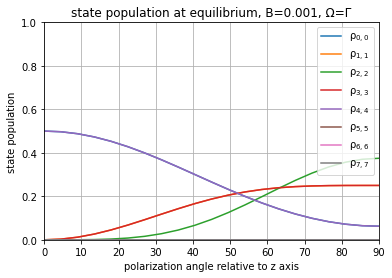

In [245]:
fig, ax = plt.subplots(figsize = (6,4))
for i in range(ntotal):
    ax.plot(varlist/np.pi*180, ρ_equ[:,i,i], label = f"ρ$_{{{i},{i}}}$")
ax.legend()
ax.set_xlim([0,90])
ax.set_ylim([0,1])
ax.set_title('state population at equilibrium, B=0.001, Ω=Γ')
ax.set_xlabel('polarization angle relative to z axis')
ax.set_ylabel('state population')
ax.grid()


# sweep one parameter at a time and monitor population change
## sweep angle at B = 0.15, Omega = Gamma

In [71]:
# creating the parameter space to scan
varlist = np.linspace(0,np.pi/2,5)
params = varlist

Main.params = params
Main.eval("@everywhere params = $params")

Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    pnew = ModelingToolkit.varmap_to_vars([
        θ => params[i],
        B => 0.15,
        Δ => 0,
        Ω => 1,
        g => 1,
        Γ => 1,
        icomplex => im
        ], parameters(bloch))
   remake(prob, p = pnew)
end
""")

Main.eval("""
@everywhere function output_func(sol,i)
           return [sol.t, real(sol.u)], false
       end
""")

Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [72]:
# solve the EnsembleProblem
# EnsembleDistributed() is the parallel solver method. See DifferentialEquations.jl for more options.
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                   save_everystep = true; trajectories = size(params)[1], adaptive=true, 
                   abstol = 1e-9, reltol =1e-6)
sim.elapsedTime
""")

0.1438274

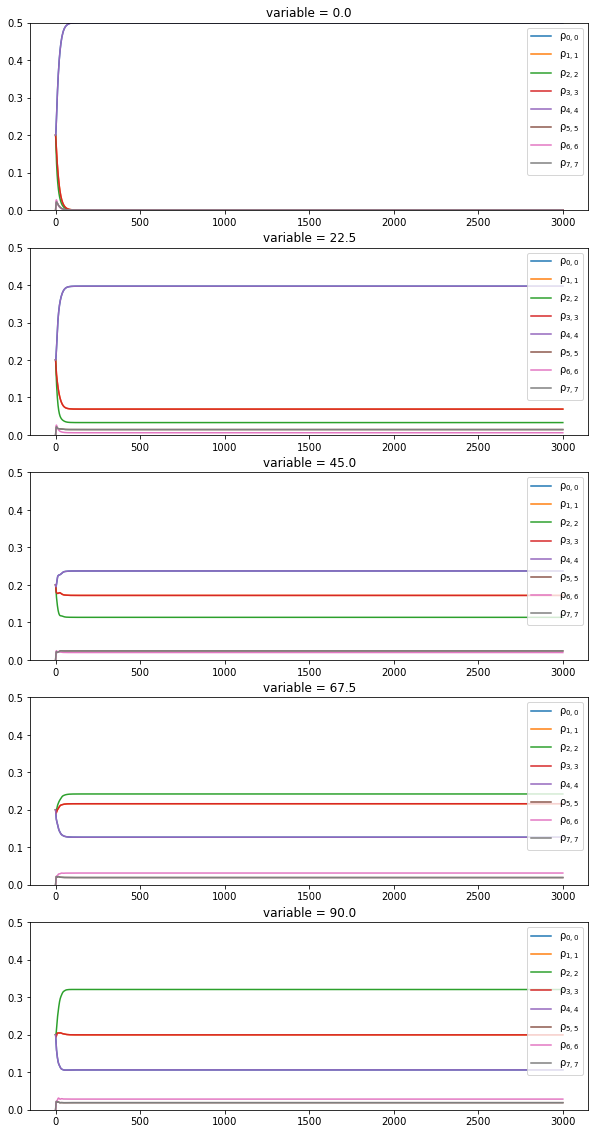

In [73]:
fig, ax = plt.subplots(len(varlist), 1, figsize = (10, len(varlist)*4))
for varindex in range(len(varlist)):
    time = np.array(Main.eval(f"sim.u[{varindex+1}][1]"))
    population = np.array(Main.eval(f"sim.u[{varindex+1}][2]")).reshape(-1, ntotal, ntotal)
    for stateindex in range(ntotal):
        ax[varindex].plot(time, population[:,stateindex, stateindex], label = f"ρ$_{{{stateindex},{stateindex}}}$")
        ax[varindex].legend()
        ax[varindex].set_ylim([0, 0.5])
#         ax[varindex].set_xlim([0, 200])
        titletemp = varlist[varindex]/np.pi*180
        ax[varindex].set_title(f"variable = {titletemp}")


# sweep one parameter at a time and monitor population change
## sweep angle at B = ?, Omega = Gamma

In [113]:
# creating the parameter space to scan
varlist = np.linspace(0,np.pi/2,5)
params = varlist

Main.params = params
Main.eval("@everywhere params = $params")

Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    pnew = ModelingToolkit.varmap_to_vars([
        θ => params[i],
        B => 5,
        Δ => 0,
        Ω => 1,
        g => 1,
        Γ => 1,
        icomplex => im
        ], parameters(bloch))
   remake(prob, p = pnew)
end
""")

Main.eval("""
@everywhere function output_func(sol,i)
           return [sol.t, real(sol.u)], false
       end
""")

Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [114]:
# solve the EnsembleProblem
# EnsembleDistributed() is the parallel solver method. See DifferentialEquations.jl for more options.
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                   save_everystep = true; trajectories = size(params)[1], adaptive=true, 
                   abstol = 1e-9, reltol =1e-6)
sim.elapsedTime
""")

3.6302522

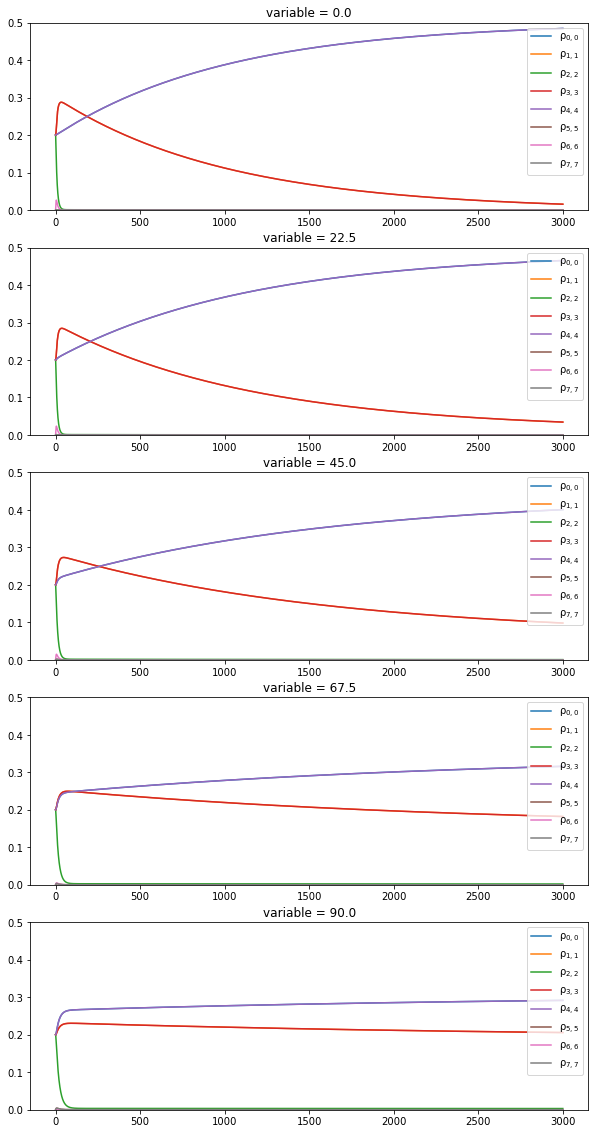

In [115]:
fig, ax = plt.subplots(len(varlist), 1, figsize = (10, len(varlist)*4))
for varindex in range(len(varlist)):
    time = np.array(Main.eval(f"sim.u[{varindex+1}][1]"))
    population = np.array(Main.eval(f"sim.u[{varindex+1}][2]")).reshape(-1, ntotal, ntotal)
    for stateindex in range(ntotal):
        ax[varindex].plot(time, population[:,stateindex, stateindex], label = f"ρ$_{{{stateindex},{stateindex}}}$")
        ax[varindex].legend(loc = 1)
        ax[varindex].set_ylim([0, 0.5])
#         ax[varindex].set_xlim([0, 200])
        titletemp = varlist[varindex]/np.pi*180
        ax[varindex].set_title(f"variable = {titletemp}")


Text(0, 0.5, 'total excited state population near equilibrium')

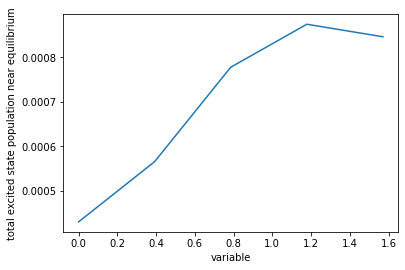

In [116]:
excpop = np.zeros(len(varlist))
for varindex in range(len(varlist)):
    time = np.array(Main.eval(f"sim.u[{varindex+1}][1]"))
    population = np.array(Main.eval(f"sim.u[{varindex+1}][2]")).reshape(-1, ntotal, ntotal)
    for stateindex in range(nground, ntotal):
#         excpop[varindex] = excpop[varindex] + np.trapz(population[:,stateindex, stateindex], x = time[:100])
        excpop[varindex] = excpop[varindex] + np.trapz(population[100:,stateindex, stateindex], x = time[100:])/(time[-1]-time[100])

fig, ax = plt.subplots(figsize = (6,4))
ax.plot(varlist, excpop)
ax.set_xlabel('variable')
ax.set_ylabel('total excited state population near equilibrium')


Text(0, 0.5, 'total excited state population including start time')

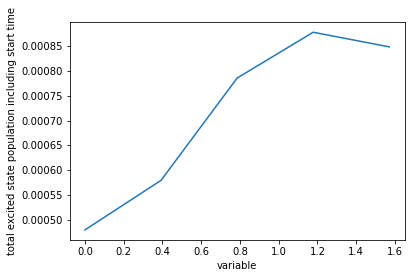

In [117]:
excpop = np.zeros(len(varlist))
for varindex in range(len(varlist)):
    time = np.array(Main.eval(f"sim.u[{varindex+1}][1]"))
    population = np.array(Main.eval(f"sim.u[{varindex+1}][2]")).reshape(-1, ntotal, ntotal)
    for stateindex in range(nground, ntotal):
#         excpop[varindex] = excpop[varindex] + np.trapz(population[:100,stateindex, stateindex], x = time[:100])
        excpop[varindex] = excpop[varindex] + np.trapz(population[:,stateindex, stateindex], x = time[:])/(time[-1]-time[0])

fig, ax = plt.subplots(figsize = (6,4))
ax.plot(varlist, excpop)
ax.set_xlabel('variable')
ax.set_ylabel('total excited state population including start time')


Text(0, 0.5, '# photon scattered at early stage')

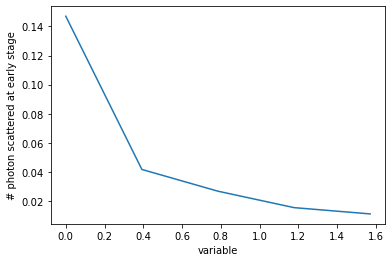

In [118]:
excpop = np.zeros(len(varlist))
for varindex in range(len(varlist)):
    time = np.array(Main.eval(f"sim.u[{varindex+1}][1]"))
    population = np.array(Main.eval(f"sim.u[{varindex+1}][2]")).reshape(-1, ntotal, ntotal)
    for stateindex in range(nground, ntotal):
        excpop[varindex] = excpop[varindex] + np.trapz(population[:100,stateindex, stateindex], x = time[:100])
#         excpop[varindex] = excpop[varindex] + np.trapz(population[10:,stateindex, stateindex], x = time[10:])/(time[-1]-time[10])

fig, ax = plt.subplots(figsize = (6,4))
ax.plot(varlist, excpop)
ax.set_xlabel('variable')
ax.set_ylabel('# photon scattered at early stage')


Text(0, 0.5, 'total excited state population in total')

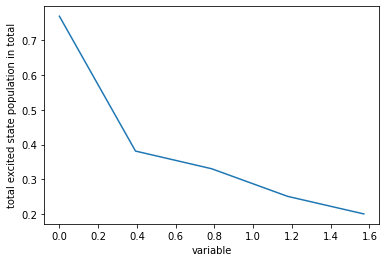

In [119]:
excpop = np.zeros(len(varlist))
for varindex in range(len(varlist)):
    time = np.array(Main.eval(f"sim.u[{varindex+1}][1]"))
    population = np.array(Main.eval(f"sim.u[{varindex+1}][2]")).reshape(-1, ntotal, ntotal)
    for stateindex in range(nground, ntotal):
        excpop[varindex] = excpop[varindex] + np.trapz(population[:1000,stateindex, stateindex], x = time[:1000])
#         excpop[varindex] = excpop[varindex] + np.trapz(population[10:,stateindex, stateindex], x = time[10:])/(time[-1]-time[10])

fig, ax = plt.subplots(figsize = (6,4))
ax.plot(varlist, excpop)
ax.set_xlabel('variable')
ax.set_ylabel('total excited state population in total')


# sweep one parameter at a time and monitor population change
## sweep angle at B = ?, Omega = 10*Gamma

In [159]:
# creating the parameter space to scan
varlist = np.linspace(0,np.pi/2,5)
params = varlist

Main.params = params
Main.eval("@everywhere params = $params")

Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    pnew = ModelingToolkit.varmap_to_vars([
        θ => params[i],
        B => 15,
        Δ => 0,
        Ω => 10,
        g => 1,
        Γ => 1,
        icomplex => im
        ], parameters(bloch))
   remake(prob, p = pnew)
end
""")

Main.eval("""
@everywhere function output_func(sol,i)
           return [sol.t, real(sol.u)], false
       end
""")

Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [160]:
# solve the EnsembleProblem
# EnsembleDistributed() is the parallel solver method. See DifferentialEquations.jl for more options.
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                   save_everystep = true; trajectories = size(params)[1], adaptive=true, 
                   abstol = 1e-9, reltol =1e-6)
sim.elapsedTime
""")

11.368373

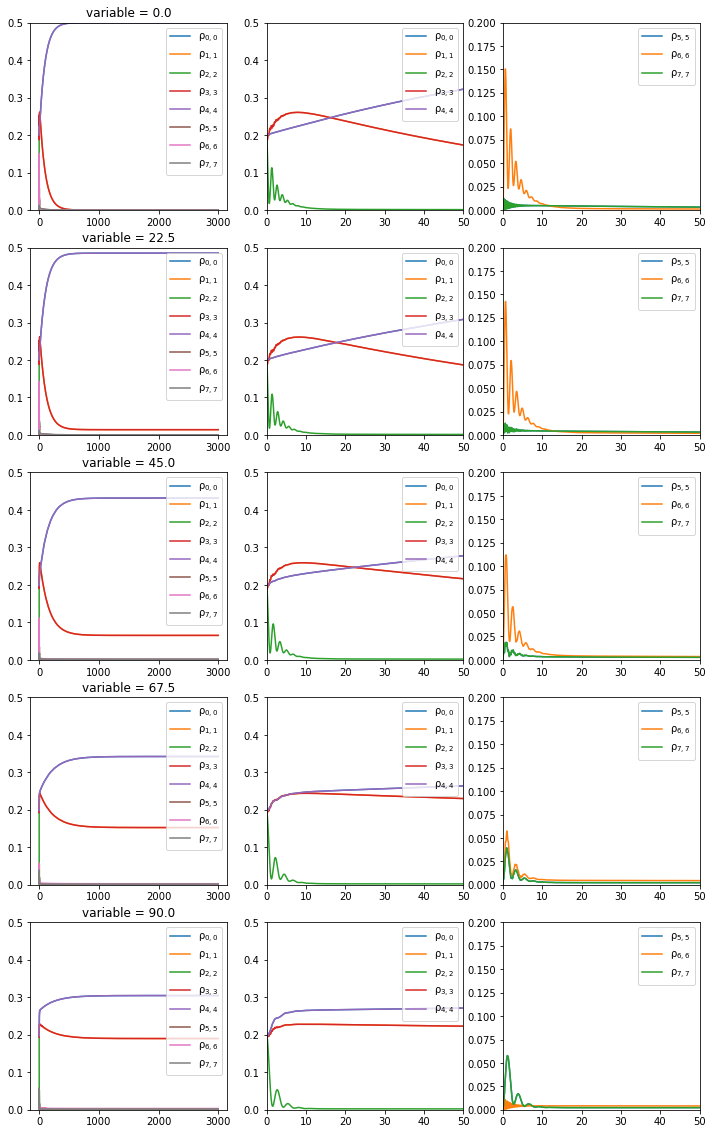

In [161]:
fig, ax = plt.subplots(len(varlist), 3, figsize = (12, len(varlist)*4))
for varindex in range(len(varlist)):
    time = np.array(Main.eval(f"sim.u[{varindex+1}][1]"))
    population = np.array(Main.eval(f"sim.u[{varindex+1}][2]")).reshape(-1, ntotal, ntotal)
    for stateindex in range(ntotal):
        ax[varindex,0].plot(time, population[:,stateindex, stateindex], label = f"ρ$_{{{stateindex},{stateindex}}}$")
        ax[varindex,0].legend(loc = 1)
        ax[varindex,0].set_ylim([0, 0.5])
#         ax[varindex].set_xlim([0, 200])
        titletemp = varlist[varindex]/np.pi*180
        ax[varindex,0].set_title(f"variable = {titletemp}")
        
        if stateindex < 5:
            ax[varindex,1].plot(time, population[:,stateindex, stateindex], label = f"ρ$_{{{stateindex},{stateindex}}}$")
            ax[varindex,1].legend(loc = 1)
            ax[varindex,1].set_ylim([0, 0.5])
            ax[varindex,1].set_xlim([0, 50])
            titletemp = varlist[varindex]/np.pi*180
            
        if stateindex > 4:
            ax[varindex,2].plot(time, population[:,stateindex, stateindex], label = f"ρ$_{{{stateindex},{stateindex}}}$")
            ax[varindex,2].legend(loc = 1)
            ax[varindex,2].set_ylim([0, 0.2])
            ax[varindex,2].set_xlim([0, 50])
            titletemp = varlist[varindex]/np.pi*180

Text(0, 0.5, 'total excited state population near equilibrium')

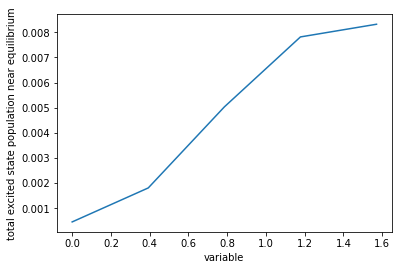

In [162]:
excpop = np.zeros(len(varlist))
for varindex in range(len(varlist)):
    time = np.array(Main.eval(f"sim.u[{varindex+1}][1]"))
    population = np.array(Main.eval(f"sim.u[{varindex+1}][2]")).reshape(-1, ntotal, ntotal)
    for stateindex in range(nground, ntotal):
#         excpop[varindex] = excpop[varindex] + np.trapz(population[:,stateindex, stateindex], x = time[:100])
        excpop[varindex] = excpop[varindex] + np.trapz(population[100:,stateindex, stateindex], x = time[100:])/(time[-1]-time[100])

fig, ax = plt.subplots(figsize = (6,4))
ax.plot(varlist, excpop)
ax.set_xlabel('variable')
ax.set_ylabel('total excited state population near equilibrium')


Text(0, 0.5, 'total excited state population including start time')

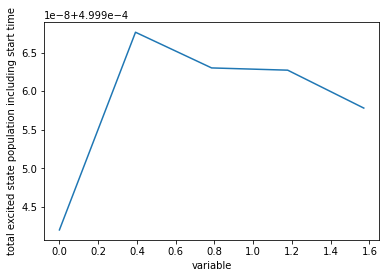

In [142]:
excpop = np.zeros(len(varlist))
for varindex in range(len(varlist)):
    time = np.array(Main.eval(f"sim.u[{varindex+1}][1]"))
    population = np.array(Main.eval(f"sim.u[{varindex+1}][2]")).reshape(-1, ntotal, ntotal)
    for stateindex in range(nground, ntotal):
#         excpop[varindex] = excpop[varindex] + np.trapz(population[:100,stateindex, stateindex], x = time[:100])
        excpop[varindex] = excpop[varindex] + np.trapz(population[:,stateindex, stateindex], x = time[:])/(time[-1]-time[0])

fig, ax = plt.subplots(figsize = (6,4))
ax.plot(varlist, excpop)
ax.set_xlabel('variable')
ax.set_ylabel('total excited state population including start time')


Text(0, 0.5, '# photon scattered at early stage')

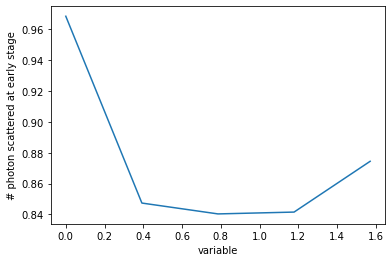

In [125]:
excpop = np.zeros(len(varlist))
for varindex in range(len(varlist)):
    time = np.array(Main.eval(f"sim.u[{varindex+1}][1]"))
    population = np.array(Main.eval(f"sim.u[{varindex+1}][2]")).reshape(-1, ntotal, ntotal)
    for stateindex in range(nground, ntotal):
        excpop[varindex] = excpop[varindex] + np.trapz(population[:100,stateindex, stateindex], x = time[:100])
#         excpop[varindex] = excpop[varindex] + np.trapz(population[10:,stateindex, stateindex], x = time[10:])/(time[-1]-time[10])

fig, ax = plt.subplots(figsize = (6,4))
ax.plot(varlist, excpop)
ax.set_xlabel('variable')
ax.set_ylabel('# photon scattered at early stage')


Text(0, 0.5, 'total excited state population in total')

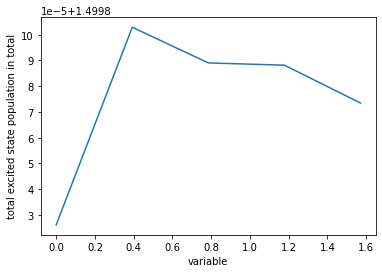

In [126]:
excpop = np.zeros(len(varlist))
for varindex in range(len(varlist)):
    time = np.array(Main.eval(f"sim.u[{varindex+1}][1]"))
    population = np.array(Main.eval(f"sim.u[{varindex+1}][2]")).reshape(-1, ntotal, ntotal)
    for stateindex in range(nground, ntotal):
        excpop[varindex] = excpop[varindex] + np.trapz(population[:1000,stateindex, stateindex], x = time[:1000])
#         excpop[varindex] = excpop[varindex] + np.trapz(population[10:,stateindex, stateindex], x = time[10:])/(time[-1]-time[10])

fig, ax = plt.subplots(figsize = (6,4))
ax.plot(varlist, excpop)
ax.set_xlabel('variable')
ax.set_ylabel('total excited state population in total')


# sweep one parameter at a time and monitor population change
## sweep Omega at theta = 60deg, B = ?

In [183]:
# creating the parameter space to scan
varlist = np.linspace(0,100,10)
params = varlist

Main.params = params
Main.eval("@everywhere params = $params")

Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    pnew = ModelingToolkit.varmap_to_vars([
        θ => 60/180*pi,
        B => 2,
        Δ => 0,
        Ω => params[i],
        g => 1,
        Γ => 1,
        icomplex => im
        ], parameters(bloch))
   remake(prob, p = pnew)
end
""")

Main.eval("""
@everywhere function output_func(sol,i)
           return [sol.t, real(sol.u)], false
       end
""")

Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [184]:
# solve the EnsembleProblem
# EnsembleDistributed() is the parallel solver method. See DifferentialEquations.jl for more options.
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                   save_everystep = true; trajectories = size(params)[1], adaptive=true, 
                   abstol = 1e-9, reltol =1e-6)
sim.elapsedTime
""")

4.8136968

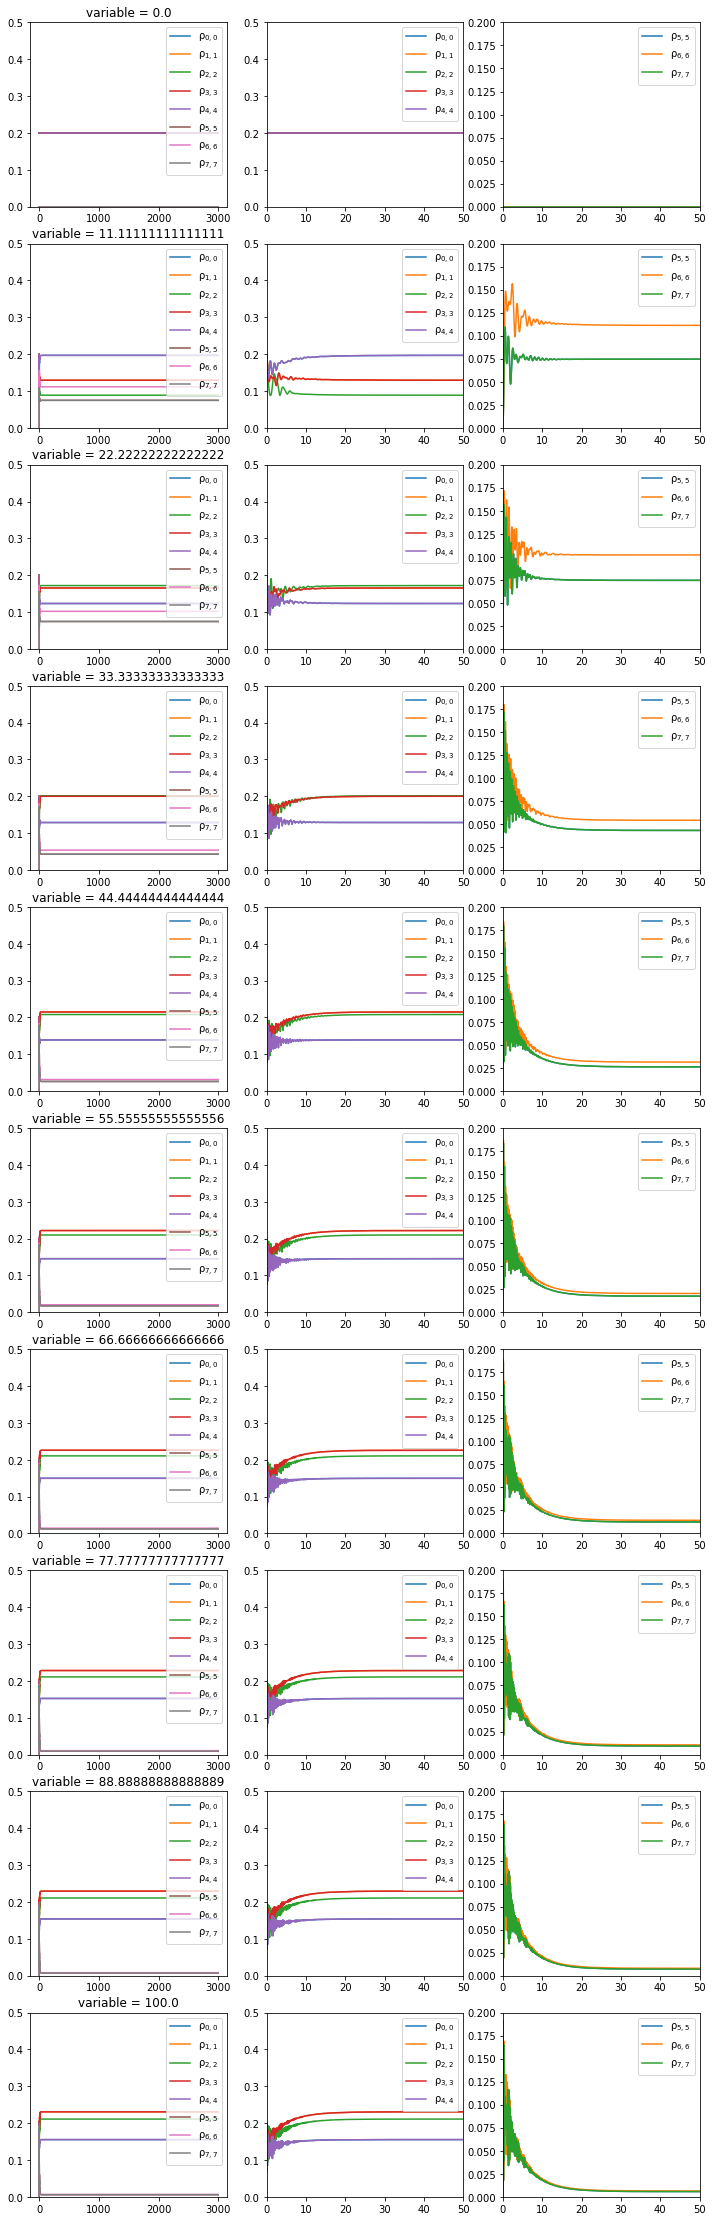

In [185]:
fig, ax = plt.subplots(len(varlist), 3, figsize = (12, len(varlist)*4))
for varindex in range(len(varlist)):
    time = np.array(Main.eval(f"sim.u[{varindex+1}][1]"))
    population = np.array(Main.eval(f"sim.u[{varindex+1}][2]")).reshape(-1, ntotal, ntotal)
    for stateindex in range(ntotal):
        ax[varindex,0].plot(time, population[:,stateindex, stateindex], label = f"ρ$_{{{stateindex},{stateindex}}}$")
        ax[varindex,0].legend(loc = 1)
        ax[varindex,0].set_ylim([0, 0.5])
#         ax[varindex].set_xlim([0, 200])
        titletemp = varlist[varindex]
        ax[varindex,0].set_title(f"variable = {titletemp}")
        
        if stateindex < 5:
            ax[varindex,1].plot(time, population[:,stateindex, stateindex], label = f"ρ$_{{{stateindex},{stateindex}}}$")
            ax[varindex,1].legend(loc = 1)
            ax[varindex,1].set_ylim([0, 0.5])
            ax[varindex,1].set_xlim([0, 50])
            
        if stateindex > 4:
            ax[varindex,2].plot(time, population[:,stateindex, stateindex], label = f"ρ$_{{{stateindex},{stateindex}}}$")
            ax[varindex,2].legend(loc = 1)
            ax[varindex,2].set_ylim([0, 0.2])
            ax[varindex,2].set_xlim([0, 50])


Text(0, 0.5, 'total excited state population near equilibrium')

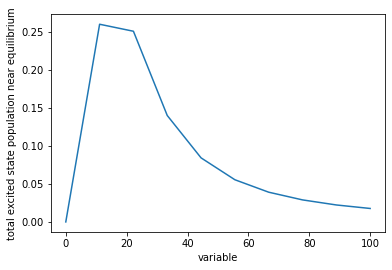

In [186]:
excpop = np.zeros(len(varlist))
for varindex in range(len(varlist)):
    time = np.array(Main.eval(f"sim.u[{varindex+1}][1]"))
    population = np.array(Main.eval(f"sim.u[{varindex+1}][2]")).reshape(-1, ntotal, ntotal)
    timeindex = np.where(time>1000)[0][0]
    for stateindex in range(nground, ntotal):
#         excpop[varindex] = excpop[varindex] + np.trapz(population[:,stateindex, stateindex], x = time[:100])
        excpop[varindex] = excpop[varindex] + np.trapz(population[timeindex:,stateindex, stateindex], x = time[timeindex:])/(time[-1]-time[timeindex])

fig, ax = plt.subplots(figsize = (6,4))
ax.plot(varlist, excpop)
ax.set_xlabel('variable')
ax.set_ylabel('total excited state population near equilibrium')


In [181]:
np.where(time>1000)[0][0]

8

In [172]:
population[:,1,1]

array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2])

# this is for using a different hamiltonian

In [89]:
hbar=1.054*1E-34; #[Js]
k_b=1.381*1E-23; #[J/K]
c=299792000; #[m/s]
eps_0=8.854*1E-12; #[F/m]
a0=5.29*1E-11; #[m]
q_e=1.602*1E-19; #[C]
Bohr_mag=1.39962449/1000*2*np.pi; #[GHz/G]

nground = 5
nexcite = 3
ntotal = 8

In [90]:
rabi_matrix = np.zeros([ntotal,ntotal,3])
rabi_matrix[:,:,0] = np.genfromtxt('rabimatrix53toy1.csv',delimiter=',')
rabi_matrix[:,:,1] = np.genfromtxt('rabimatrix53toy2.csv',delimiter=',')
rabi_matrix[:,:,2] = np.genfromtxt('rabimatrix53toy3.csv',delimiter=',')

In [191]:
E0 = Symbol(u'E0', real = True)
Ee = Symbol(u'Ee', real = True)

ω = Symbol(u'ω', real = True)
Ω = Symbol(u'Ω', real = True)
Δ = Symbol(u'Δ', real = True)
g = Symbol(u'g', real = True)

θ = Symbol(u'θ', real = True)
B = Symbol(u'B', real = True)

In [192]:
ham = Hamiltonian(ntotal)
ham.addEnergies([E0-2*g*B,E0-g*B,E0,E0+g*B, E0+2*g*B,
                 Ee,Ee,Ee])

In [193]:
for i in range(nground):
    for j in range(nground, ntotal):
        if rabi_matrix[i, j, 0] != 0:
            prefactor = sin(θ)*(-1/2+1j*1/2)
            ham.addCoupling(i, j, prefactor*Ω*rabi_matrix[i,j,0], ω)
        if rabi_matrix[i, j, 1] != 0:
            prefactor = cos(θ)
            ham.addCoupling(i, j, prefactor*Ω*rabi_matrix[i,j,1], ω)
        if rabi_matrix[i, j, 2] != 0:
            prefactor = sin(θ)*(1/2+1j*1/2)
            ham.addCoupling(i, j, prefactor*Ω*rabi_matrix[i,j,2], ω)

In [194]:
ham.eqnTransform()
ham.defineZero(Ee)
ham.defineEnergyDetuning(E0, Ee, Δ, ω)

In [195]:
ham.transformed

Matrix([
[                     -2*B*g - 1.0*Δ,                                   0,                                   0,                                  0,                                  0, -0.144337567297406*Ω*(1 + I)*sin(θ),                                   0,                                   0],
[                                  0,                        -B*g - 1.0*Δ,                                   0,                                  0,                                  0,          0.204124145231932*Ω*cos(θ), -0.102062072615966*Ω*(1 + I)*sin(θ),                                   0],
[                                  0,                                   0,                              -1.0*Δ,                                  0,                                  0,  0.058925565098879*Ω*(1 - I)*sin(θ),          0.235702260395516*Ω*cos(θ), -0.058925565098879*Ω*(1 + I)*sin(θ)],
[                                  0,                                   0,                             

In [196]:
ham.hamiltonian

Matrix([
[                                              -2*B*g + E0,                                                         0,                                                          0,                                                          0,                                                          0,  -0.288675134594813*Ω*(0.5 + 0.5*I)*exp(1.0*I*t*ω)*sin(θ),                                                         0,                                                         0],
[                                                        0,                                                 -B*g + E0,                                                          0,                                                          0,                                                          0,                 0.204124145231932*Ω*exp(1.0*I*t*ω)*cos(θ),  -0.204124145231932*Ω*(0.5 + 0.5*I)*exp(1.0*I*t*ω)*sin(θ),                                                         0],
[                                    

In [99]:
transition_strengths=np.zeros([ntotal,ntotal]);
for i in range(ntotal):
    for f in range(ntotal):
        for p in range(3):
            transition_strengths[i,f]=transition_strengths[i,f]+rabi_matrix[i,f,p]**2

In [100]:
BR = np.zeros([ntotal, ntotal])
for i in range(ntotal):
    sums=0
    for f in range(ntotal):
        sums=sums+transition_strengths[i,f]
        
    for f in range(ntotal):
        BR[i,f]=transition_strengths[i,f]/sums
        
for i in range(nground):
    BR[i,:]=0

In [101]:
BR[nground:,:]

array([[0.6, 0.3, 0.1, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.3, 0.4, 0.3, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.1, 0.3, 0.6, 0. , 0. , 0. ]])

In [102]:
Γ = Symbol(u'Γ', real = True)
dis = Dissipator(ntotal)

for exct in tqdm(range(nground, ntotal)):
    for grnd in range(nground):
        if BR[exct, grnd] != 0:
            dis.addDecay(exct, grnd, Γ * BR[exct, grnd])

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.22it/s]


In [103]:
dis.dissipator

Matrix([
[            0.6*Γ*ρ₅₅(t),                        0,                                        0,                        0,                        0,            -0.5*Γ*ρ₀₅(t),            -0.5*Γ*ρ₀₆(t), -0.5*Γ*ρ₀₇(t)],
[                       0,  0.3*Γ*(ρ₅₅(t) + ρ₆₆(t)),                                        0,                        0,                        0,            -0.5*Γ*ρ₁₅(t),            -0.5*Γ*ρ₁₆(t), -0.5*Γ*ρ₁₇(t)],
[                       0,                        0, Γ*(0.1*ρ₅₅(t) + 0.4*ρ₆₆(t) + 0.1*ρ₇₇(t)),                        0,                        0,            -0.5*Γ*ρ₂₅(t),            -0.5*Γ*ρ₂₆(t), -0.5*Γ*ρ₂₇(t)],
[                       0,                        0,                                        0,  0.3*Γ*(ρ₆₆(t) + ρ₇₇(t)),                        0,            -0.5*Γ*ρ₃₅(t),            -0.5*Γ*ρ₃₆(t), -0.5*Γ*ρ₃₇(t)],
[                       0,                        0,                                        0,                        0,           

In [197]:
%%time
bloch = BlochEquations(ntotal, dis.density_matrix, ham.transformed, dis.dissipator)

start generateEquations
Wall time: 478 ms


In [198]:
y0 = np.zeros([ntotal, ntotal], dtype = complex)
for i in range(nground):
    y0[i,i] = 1/nground
y0 = y0.flatten()

In [202]:
from sympy import MutableDenseMatrix, conjugate, Function, Symbol

t = Symbol('t', real = True)

hamiltonian_symbols = ham.transformed.free_symbols
dissipator_symbols = dis.dissipator.free_symbols
dissipator_symbols = set([d for d in dissipator_symbols if str(d)[0] not in ['ρ', 't']])

for s in list(hamiltonian_symbols) + list(dissipator_symbols):
    Main.eval(f"""
                @everywhere @parameters {str(s)}
                tmp = 0
            """);


lx, ly = ham.transformed.shape
Main.eval(f"""
            @everywhere begin
            H = zeros(Num, {lx}, {ly})
            L = zeros(Num, {lx}, {ly})
            @variables t ρ[1:{lx},1:{ly}](t)
            @parameters icomplex
            D = Differential(t)
            tmp = 0
            end
            """);

# the code below is to transform the symbolic version of Sympy into a form usable with Julia
diss = MutableDenseMatrix(dis.dissipator.copy())

for i in range(lx):
    for j in range(i,ly):
        tmp = Function(u'ρ{0}{1}'.format(chr(0x2080+i), 
                                         chr(0x2080+j)))
        tmp1 = Function(u'ρ[{0},{1}]'.format(j+1, i+1))
        diss = diss.subs(conjugate(tmp(t)), tmp1(t))
            
for i in range(lx):
    for j in range(i,ly):
        tmp = Function(u'ρ{0}{1}'.format(chr(0x2080+i), 
                                         chr(0x2080+j)))
        tmp1 = Function(u'ρ[{0},{1}]'.format(i+1, j+1))
        diss = diss.subs(tmp(t), tmp1(t))


# Creating the Hamiltonian matrix and Dissipator matrix in Julia
for idx in range(1,lx+1):
    for idy in range(1,ly+1):
        hval = str(ham.transformed[idx-1,idy-1]).replace("I", "icomplex")
        dval = str(diss[idx-1, idy-1])
        dval = dval.replace('(t)', '')
        Main.eval(f"""
                @everywhere begin
                H[{idx},{idy}] = {hval}
                L[{idx},{idy}] = {dval}
                tmp = 0
                end
                """);
        
# ham_pars = ham.transformed.free_symbols

In [203]:
# Creating the system of equations
ham_string = ','.join([str(h) for h in hamiltonian_symbols])
diss_string = ','.join([str(d) for d in dissipator_symbols])

Main.eval(f"""
@everywhere begin
    eq = -icomplex*Symbolics.scalarize(H*ρ-ρ*H) + L
    eqns = [D(ρ[idx,idy]) ~ eq[idx,idy] for idx in 1:{lx} for idy in 1:{ly}];
    bloch = ODESystem(eqns)
    tmp = 0
end
""");

In [204]:
# initial populations
y0 = np.zeros([ham.levels, ham.levels], dtype = complex)
for _ in range(nground):
    y0[_,_] = 1/nground
Main.ρ_ini = y0
Main.eval("@everywhere ρ_ini = $ρ_ini")

In [205]:
print(hamiltonian_symbols,dissipator_symbols)

{θ, g, Ω, B, Δ} {Γ}


In [206]:
Main.eval("""
    @everywhere begin
    Γ_val = 1
    Δgroup = 0E-3
    Ω_val = 3*Γ_val
    u0 = [ρ[idx,idy] => ρ_ini[idx,idy] for idx in 1:size(ρ_ini)[1] for idy in 1:size(ρ_ini)[1]]
    tmp =0;
end
""");

In [207]:
# setting up the parameters of the model and initial conditions
Main.eval("""
    @everywhere begin
    p = [
    θ => 60*pi/180,
    B => 3,
    Δ => Δgroup,
    Ω => Ω_val,
    g => 1,
    Γ => Γ_val,
    icomplex => im
    ]
    u0 = [ρ[idx,idy] => ρ_ini[idx,idy] for idx in 1:size(ρ_ini)[1] for idy in 1:size(ρ_ini)[1]]
    tmp =0;
end
""");

In [208]:
# creating the problem to solve
Main.eval("""
@everywhere begin
    tspan = (0.0, 3000.)
    prob = ODEProblem(bloch, ρ_ini, tspan, p, jac = true)
end
""");

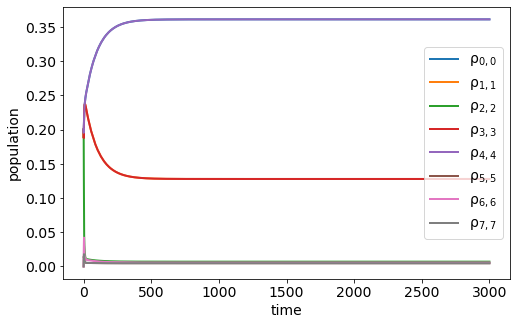

In [209]:
# solving the ODEProblem, keep in mind that the first run compiles called functions
# the first run will be significantly slower (due to compilation), but any subsequent solves are fast
Main.eval("@time sol = solve(prob, Tsit5(), abstol = 1e-10, reltol = 1e-10)");
ut = np.array(Main.eval("sol[:]"))
dim = int(np.sqrt(ut.shape[1]))
pop_results = np.real(np.einsum('jji->ji',ut.reshape(-1,dim, dim).T))
t_array = Main.eval("sol.t") 
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ax.plot(t_array, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$")

ax.set_xlabel('time')
ax.set_ylabel('population')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

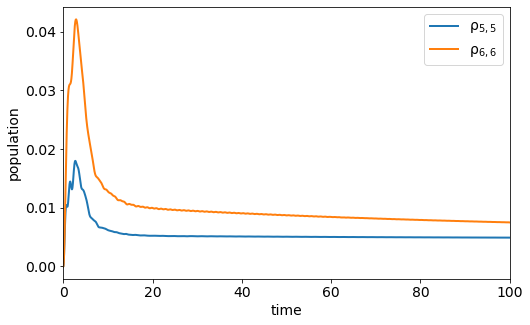

In [210]:
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    if idx in [5,6]:
        ax.plot(t_array, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$")

ax.set_xlabel('time')
ax.set_ylabel('population')
ax.set_xlim([0,100])
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

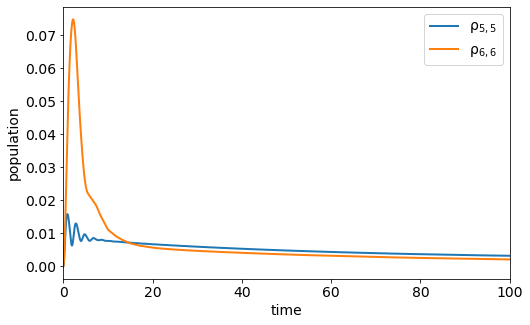

In [73]:
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    if idx in [5,6]:
        ax.plot(t_array, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$")

ax.set_xlabel('time')
ax.set_ylabel('population')
ax.set_xlim([0,100])
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

In [122]:
for idx, pop in enumerate(pop_results):
    print(idx, pop)

0 [0.2        0.2        0.20000001 ... 0.49999999 0.49999999 0.49999999]
1 [2.00000000e-01 1.99999410e-01 1.99997274e-01 ... 6.31487650e-09
 6.31346423e-09 6.31311934e-09]
2 [2.00000000e-01 1.99999212e-01 1.99996363e-01 ... 6.48105884e-11
 6.47960940e-11 6.47925544e-11]
3 [2.00000000e-01 1.99999410e-01 1.99997274e-01 ... 6.31487650e-09
 6.31346423e-09 6.31311934e-09]
4 [0.2        0.2        0.20000001 ... 0.49999999 0.49999999 0.49999999]
5 [0.00000000e+00 5.90133791e-07 2.72244450e-06 ... 6.30278459e-11
 6.30137503e-11 6.30103080e-11]
6 [0.00000000e+00 7.86863423e-07 3.63031823e-06 ... 2.18599994e-11
 2.18551106e-11 2.18539167e-11]
7 [0.00000000e+00 5.90133791e-07 2.72244450e-06 ... 6.30278459e-11
 6.30137503e-11 6.30103080e-11]


# Sweep B field and theta Omega = Gamma

In [217]:
# creating the parameter space to scan
var1list = np.linspace(0,np.pi/2,40)
var2list = np.linspace(0,1,20)
params = np.array(np.meshgrid(var1list, var2list)).T.reshape(-1,2)

Main.params = params
Main.eval("@everywhere params = $params")

Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    Δgroup = 0
    Ω_val = Γ_val
    pnew = ModelingToolkit.varmap_to_vars([
        θ => params[i,1],
        B => params[i,2],
        Δ => Δgroup,
        Ω => Ω_val,
        g => 1,
        Γ => Γ_val,
        icomplex => im
        ], parameters(bloch))
   remake(prob, p = pnew)
end
""")

Main.eval("""
@everywhere function output_func(sol,i)
           return trapz(sol.t, [real(sol.u[j][1+(6-1)*9])+real(sol.u[j][1+(7-1)*9])+real(sol.u[j][1+(8-1)*9]) for j in 1:size(sol.u)[1]]), false
       end
""")
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [218]:
# solve the EnsembleProblem
# EnsembleDistributed() is the parallel solver method. See DifferentialEquations.jl for more options.
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                   save_everystep = true; trajectories = size(params)[1], adaptive=true, 
                   abstol = 1e-9, reltol =1e-6)
sim.elapsedTime
""")

22.9100021

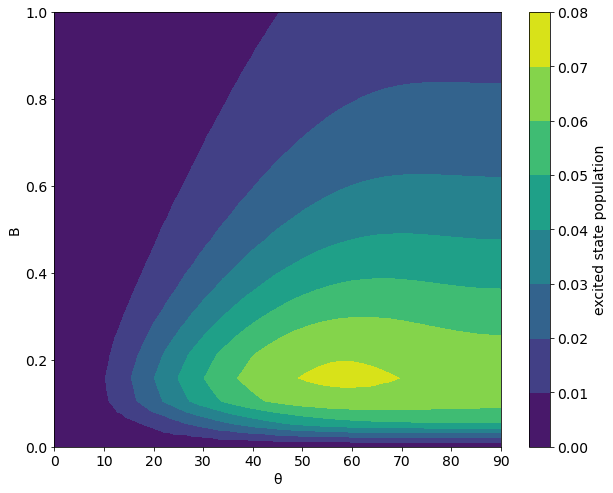

In [219]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0]*180/np.pi, params[:,1], np.array(Main.eval("sim.u"))/3000)

cbar = fig.colorbar(tcf)

ax.set_xlabel('θ')
ax.set_ylabel('B')
cbar.ax.set_ylabel('excited state population')
# ax.set_yscale('log')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)